In [1]:

import datasets
import numpy as np
import transformers

import shap

/home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sentiment Example

In [2]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

In [15]:
short_data[1]

"Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the c"

In [3]:
classifier = transformers.pipeline("sentiment-analysis", return_all_scores=True)
classifier(short_data[:2])

2025-03-08 11:24:59.306237: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 11:24:59.536599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741451099.612891   28177 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741451099.636305   28177 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 11:25:00.025182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[[{'label': 'NEGATIVE', 'score': 0.07581958174705505},
  {'label': 'POSITIVE', 'score': 0.9241803884506226}],
 [{'label': 'NEGATIVE', 'score': 0.018342511728405952},
  {'label': 'POSITIVE', 'score': 0.9816575050354004}]]

In [18]:
classifier(short_data[0])

[[{'label': 'NEGATIVE', 'score': 0.07581958174705505},
  {'label': 'POSITIVE', 'score': 0.9241803884506226}]]

In [4]:
# define the explainer
explainer = shap.Explainer(classifier)

In [5]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:6])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 7it [00:22,  3.82s/it]                       


In [6]:
shap.plots.text(shap_values[:, :, "POSITIVE"])

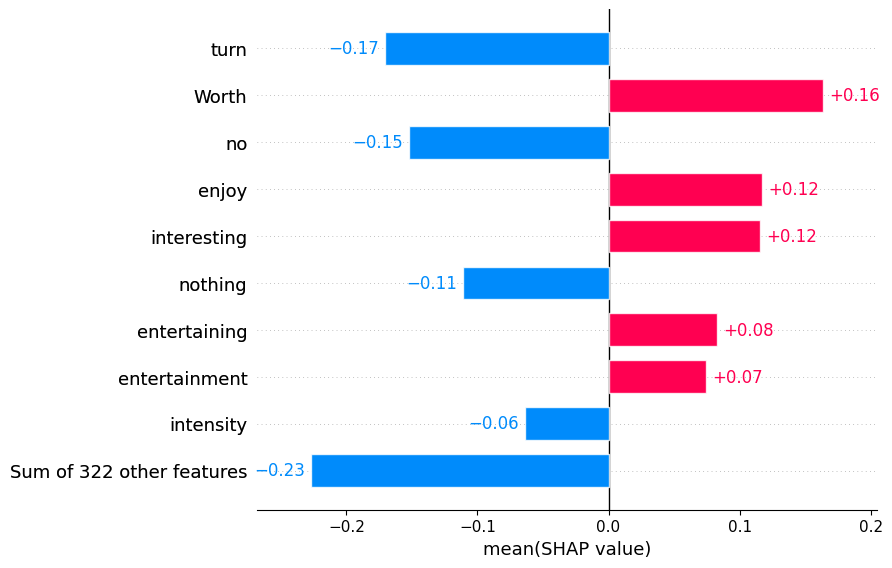

In [7]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))

# Custom Example

In [8]:
import datasets
import numpy as np
import pandas as pd
import scipy as sp
import torch
import transformers

import shap

# load the emotion dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 723405.31 examples/s]


In [9]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()
labels = sorted(model.config.label2id, key=model.config.label2id.get)


# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding="max_length", max_length=128, truncation=True) for v in x]).cuda()
    attention_mask = (tv != 0).type(torch.int64).cuda()
    outputs = model(tv, attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [10]:
method = "custom tokenizer"

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f, tokenizer, output_names=labels)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker = shap.maskers.Text(r"\W")  # this will create a basic whitespace tokenizer
    explainer = shap.Explainer(f, masker, output_names=labels)

# build a fully custom tokenizer
elif method == "custom tokenizer":
    import re

    def custom_tokenizer(s, return_offsets_mapping=True):
        """Custom tokenizers conform to a subset of the transformers API."""
        pos = 0
        offset_ranges = []
        input_ids = []
        for m in re.finditer(r"\W", s):
            start, end = m.span(0)
            offset_ranges.append((pos, start))
            input_ids.append(s[pos:start])
            pos = end
        if pos != len(s):
            offset_ranges.append((pos, len(s)))
            input_ids.append(s[pos:])
        out = {}
        out["input_ids"] = input_ids
        if return_offsets_mapping:
            out["offset_mapping"] = offset_ranges
        return out

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(f, masker, output_names=labels)

In [11]:
shap_values = explainer(data["text"][:3])

In [12]:
shap.plots.text(shap_values)

# Now onto my stuff
